# A rectangle rotation puzzle

In [196]:
import math

import numpy as np
from media_tools import *
import cv2
import math
import matplotlib.pyplot as plt


Suppose you have a rectangle 2d array described by a `(w, h)` tuple.

In [197]:
rect = np.ones((100, 200))

Let's find the coordinates of the rectangle's points and return them as a list of tuples.

In [198]:
point_names = ['top_left', 'top_right', 'bottom_right', 'bottom_left']
rect_points = [(0, 0), (0, rect.shape[1] - 1), (rect.shape[0] - 1, rect.shape[1] - 1), (rect.shape[0] - 1, 0)]

# roll the points so that bottom_left is first
point_names = point_names[1:] + point_names[:1]
rect_points = rect_points[1:] + rect_points[:1]

# interweave the point names and points
print(np.array(list(zip(point_names, rect_points))))

[['top_right' (0, 199)]
 ['bottom_right' (99, 199)]
 ['bottom_left' (99, 0)]
 ['top_left' (0, 0)]]


## Rotating points by an angle around an origin:

Suppose you want to rotate the rectangle by $\theta$ degrees clockwise around an origin point. What would be the new coordinates of the rectangle's points?

In [199]:
theta = 45

# we need a function that takes a list of points and finds the middle point.
def find_middle(points):
    x_list = [x for (x, y) in points]
    y_list = [y for (x, y) in points]
    return [np.mean(x_list), np.mean(y_list)]

# we need a function that takes a list of points, a rotation angle, and an origin point and returns the coordinates of
# the rotated points on an array.
def rotate_points_around_origin(points, angle=0, origin=(0,0), cartesian=False):
    # if no origin is given, find the middle of the points
    if origin is "centre":
        origin = find_middle(points)
    # create a rotation matrix
    if cartesian is True:
        angle = -angle
    rot_mat = cv2.getRotationMatrix2D(origin, -angle, 1)
    # rotate the points and return the result as a list of tuples
    return [tuple(np.dot(rot_mat, (x, y, 1)).astype(int)) for (x, y) in points]

In [200]:
# let's print the original points for reference
print("Original points:\n", rect_points)

# let's get the rotated points for a rotation of 45 degrees at a few different origin points
new_points_45_around_center = rotate_points_around_origin(rect_points, theta, origin="centre")
new_points_45_around_bottom_left = rotate_points_around_origin(rect_points, theta, origin=rect_points[0])

# print the results
print("Rotated points, theta = {}, origin = {}:\n".format(theta, "centre"), new_points_45_around_center)
print("Rotated points, theta = {}, origin = {}:\n".format(theta, rect_points[3]), new_points_45_around_bottom_left)


Original points:
 [(0, 199), (99, 199), (99, 0), (0, 0)]
Rotated points, theta = 45, origin = centre:
 [(-55, 134), (14, 204), (154, 64), (84, -5)]
Rotated points, theta = 45, origin = (0, 0):
 [(0, 199), (70, 269), (210, 128), (140, 58)]


## Drawing polygons from points:

Additionally, if we are going to draw the shapes, rotated, we need some functions to draw polygons.

In [201]:
# draw a polygon centered at an origin using cv2.fillPoly
def draw_poly(points, colour=(255, 255, 255, 255), crop_to_shape=False, flip_y=False):
    # create an empty array to hold the polygon
    if crop_to_shape is True:
        dim = (max([y for (x, y) in points]) - min([y for (x, y) in points]) + 1, max([x for (x, y) in points]) - min([x for (x, y) in points])+ 1, 4)
        # shift all points by the absolute of the minimum x and y values
        points = np.asarray(points) - np.asarray([(min([x for (x, y) in points])), (min([y for (x, y) in points]))])
    else:
        dim = (max([y for (x, y) in points]) + 1, max([x for (x, y) in points]) + 1, 4)
    print("dim:", dim)
    print("points:", points)
    # create the container array
    poly_array = np.zeros(dim)
    # fill the polygon
    cv2.fillPoly(poly_array, [np.asarray(points)], colour)
    if flip_y is True:
        poly_array = cv2.flip(poly_array, 0)
    return poly_array.astype(np.uint8)

dim: (201, 174, 4)
points: ((0, 0), (0, 200), (173, 100))


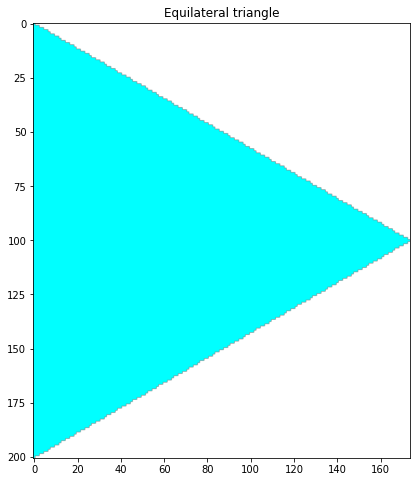

In [202]:
# given two points on an equilateral triangle, find the coordinates of the last point
equilateral_triangle_points = ((0, 0), (0, 200), tuple(np.floor(np.asarray((np.sqrt(200**2 - (200/2)**2), 200/2))).astype(int)))

# draw the equilateral triangle
equilateral_triangle = draw_poly(equilateral_triangle_points, colour=(0, 255, 255, 255))
image_tools.show_image(equilateral_triangle, axis=True, title="Equilateral triangle")

## Drawing polygons with alpha channels:

dim: (205, 155, 4)
points: [(-55, 134), (14, 204), (154, 64), (84, -5)]


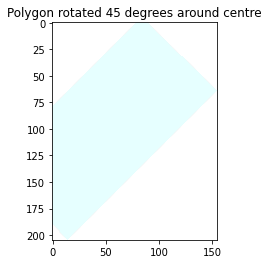

In [203]:
# get a polygon image array
rot_45_poly_around_centre = draw_poly(new_points_45_around_center, colour=(0, 255, 255, 25))
# plot the polygons separately
image_tools.show_image(rot_45_poly_around_centre, axis=True, title="Polygon rotated 45 degrees around centre", scale_ratio=1)

In [204]:
# create a blank canvas
canvas = np.zeros((300, 300, 4), np.uint8)
# canvas[:, :, 3] = 255
print("Canvas shape: \n{}" .format(canvas.shape))

# rectangle
print("Rectangle shape: \n{}".format(rect.shape))
print("Rectangle points: \n{}".format(rect_points), "\n")

# blit the the polygon onto the canvas, translated at the correct position

def find_displace(poly_points, origin = (0, 0)):
    # displace = the minimum x and y values - the origin point
    displacement = np.asarray([min([x for (x, y) in poly_points]), min([y for (x, y) in poly_points])])
    return displacement

Canvas shape: 
(300, 300, 4)
Rectangle shape: 
(100, 200)
Rectangle points: 
[(0, 199), (99, 199), (99, 0), (0, 0)] 



dim: (200, 100, 4)
points: [(0, 199), (99, 199), (99, 0), (0, 0)]


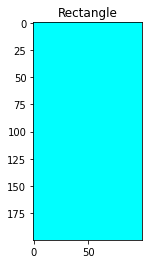

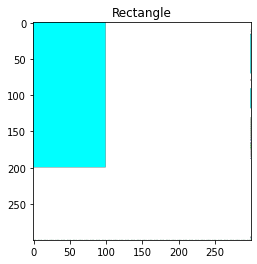

In [205]:
## get the original rectangle
poly = draw_poly(rect_points, colour=(0, 255, 255, 255))
image_tools.show_image(poly, axis=True, title="Rectangle", scale_ratio=1)
canvas_rect = data_tools.blit(poly, canvas)
image_tools.show_image(canvas_rect, axis=True, title="Rectangle", scale_ratio=1)

dim: (270, 211, 4)
points: [(0, 199), (70, 269), (210, 128), (140, 58)]


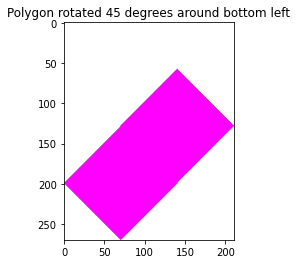

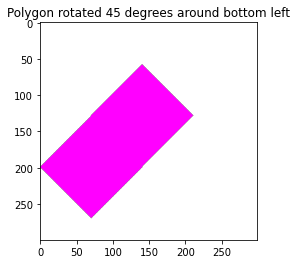

In [206]:
## get a rotated polygon
poly_rot = draw_poly(new_points_45_around_bottom_left, colour=(255, 0, 255, 255))
image_tools.show_image(poly_rot, axis=True, title="Polygon rotated 45 degrees around bottom left", scale_ratio=1)
canvas_rot_bottom_left = data_tools.blit(poly_rot, canvas)
image_tools.show_image(canvas_rot_bottom_left, axis=True, title="Polygon rotated 45 degrees around bottom left", scale_ratio=1)

We did it! we figured out how to rotate points, plot them as a polygon, and blit them to an image array! Go us!!!